In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os 
from typing import List
import pandas as pd
import matplotlib.pyplot as plt
import json
import numpy as np
from PIL import Image
import torch

from cvm import ConstantVelocityModel
from dataloader import PixWorldConverter
from metrics import AverageDisplacementError, FinalDisplacementError

### Helper Function

In [2]:
def evaluate_dataset(predictor, data: List[pd.DataFrame], obs_len: int):
    """Evaluate dataset"""
    ade = AverageDisplacementError()
    fde = FinalDisplacementError()
    obs_dataset = list(map(lambda x: x.iloc[:obs_len], data))
    gt_dataset = list(map(lambda x: x.iloc[obs_len:][["x", "y"]].values, data))

    y_hat = predictor.predict_dataset(obs_dataset)
    y_true = np.stack(gt_dataset).astype(float)

    ade.update(preds=torch.from_numpy(y_hat), target=torch.from_numpy(y_true))
    fde.update(preds=torch.from_numpy(y_hat), target=torch.from_numpy(y_true))
    ade_res = ade.compute().item()
    fde_res = fde.compute().item()
    ade.reset()
    fde.reset()
    return ade_res, fde_res

In [3]:
PREDICTION_LEN = 12
TEST_SCENARIO = "Scenario_1"
 
EXTRAS_PATH = "lhmp-thor-magni-challenge-extras"
DATA_PATH = os.path.join(EXTRAS_PATH, "data") # path to data directory 
MAPS_PATH = os.path.join(DATA_PATH, "maps") # path to obstacle maps and offsets.json

In [4]:
df = pd.read_csv(os.path.join(DATA_PATH, TEST_SCENARIO + ".csv"), index_col = "Time")
tracklets = [group for _, group in df.groupby("tracklet_id")]
len(tracklets)

2935

In [5]:
cvm_cfg = {"pred_len": PREDICTION_LEN, "v0_mode": "constant", "v0_sigma": None}
cvm = ConstantVelocityModel(cvm_cfg)

In [6]:
ade, fde = evaluate_dataset(predictor=cvm, data=tracklets, obs_len=8)
ade, fde

2935it [00:05, 519.63it/s]


(1.0720480680465698, 2.4384546279907227)

# Check predictions

In [7]:
observations = [tracklet.iloc[:8] for tracklet in tracklets]
predictions = cvm.predict_dataset(observations)
ground_truth = [tracklet.iloc[8:] for tracklet in tracklets]

2935it [00:05, 541.45it/s]


In [8]:
if MAPS_PATH:
    with open(os.path.join(MAPS_PATH, "offsets.json"), "rb") as f:
        offsets = json.load(f)
    pix2word_converters = dict(
        May=PixWorldConverter(dict(resolution_pm=0.01, offset=offsets["May"])),
        September=PixWorldConverter(dict(resolution_pm=0.01, offset=offsets["September"])),
)

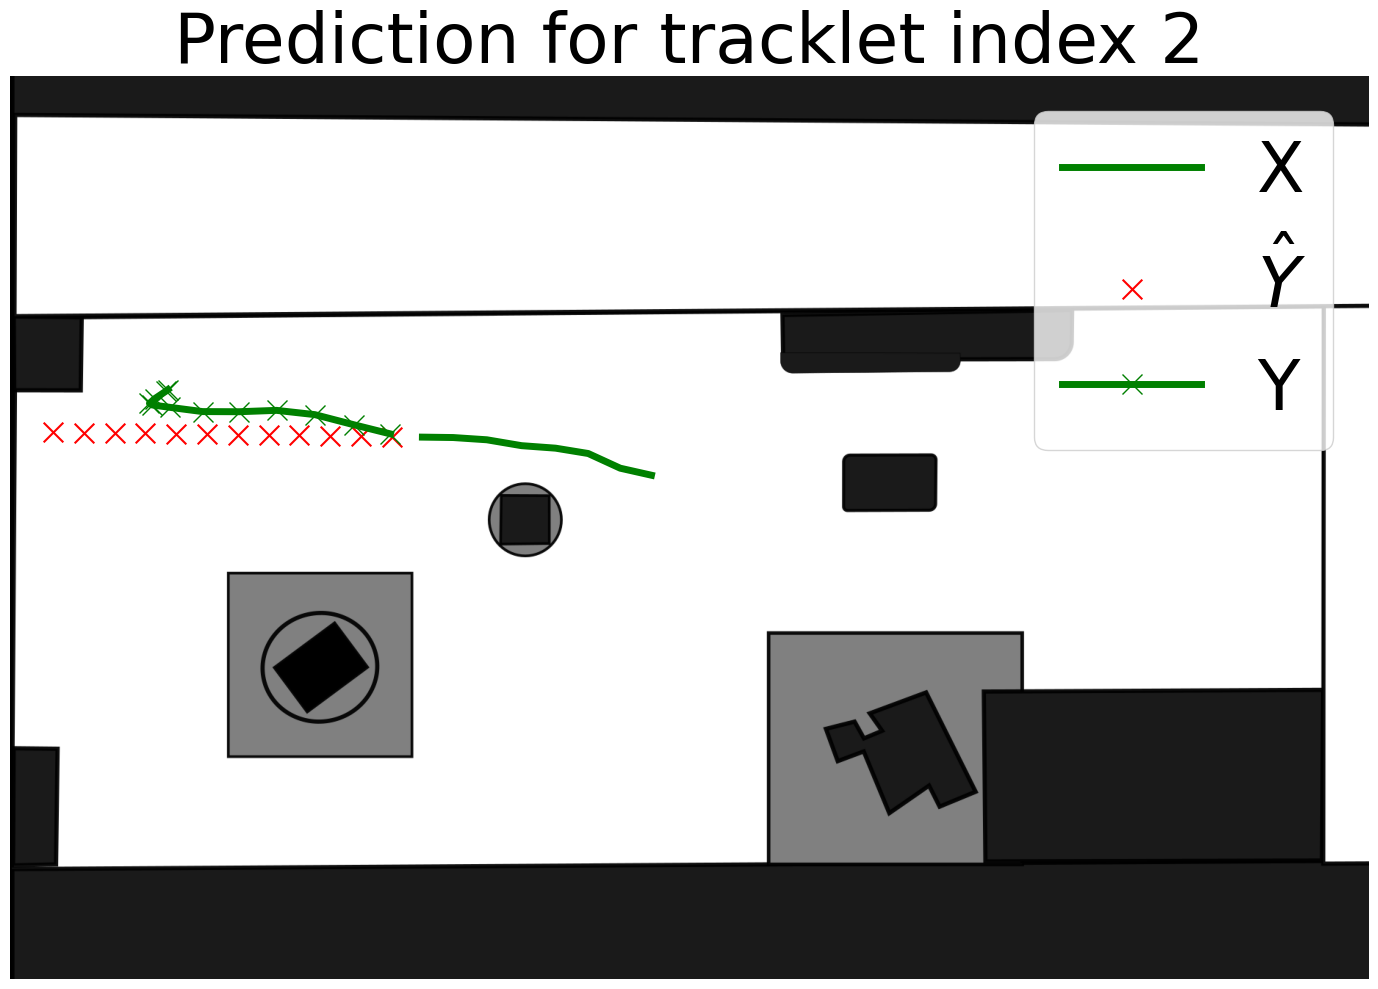

In [9]:
TRACKLET_INDEX = 2
plt.figure(figsize=(20, 10))
plt.title(f"Prediction for tracklet index {TRACKLET_INDEX}", fontsize=50)
observations_plt = observations[TRACKLET_INDEX]
predictions_plt = predictions[TRACKLET_INDEX]
ground_truth_plt = ground_truth[TRACKLET_INDEX]


if MAPS_PATH:
    map_name = observations[TRACKLET_INDEX]["map_name"].iloc[0]
    img = np.array(Image.open(os.path.join(MAPS_PATH, map_name)))
    spatial_layout = np.flipud(img[:, :, :3])
    plt.imshow(spatial_layout)
    month = "September" if map_name.startswith("3009") else "May"
    obs_px = pix2word_converters[month].convert2pixels(observations_plt[["x", "y"]].values)
    gt_px = pix2word_converters[month].convert2pixels(ground_truth_plt[["x", "y"]].values)
    observations_plt = observations_plt.copy()
    ground_truth_plt = ground_truth_plt.copy()
    observations_plt[["x", "y"]] = obs_px
    ground_truth_plt[["x", "y"]] = gt_px
    predictions_plt = pix2word_converters[month].convert2pixels(predictions_plt)
    
    
plt.plot(
    observations_plt["x"],
    observations_plt["y"],
    color="green",
    label = "X",
    linewidth=5,
)
plt.scatter(
    predictions_plt[:, 0],
    predictions_plt[:, 1],
    color="red",
    marker="x", 
    label = r"$\hat{Y}$",
    s=200,
)
plt.plot(
    ground_truth_plt["x"],
    ground_truth_plt["y"],
    color="green",
    marker="x", 
    label = r"Y",
    linewidth=5,
    markersize=15,
)
plt.legend(fontsize=50);
plt.axis("off")
plt.xlim([0, 1850])
plt.ylim([500, 1730])
plt.tight_layout()